In [71]:
import pandas as pd
import re
import pedpy
import shapely
import matplotlib.pyplot as plt

from pedpy import TrajectoryData
from pedpy import WalkableArea
from pedpy import plot_measurement_setup
from pathlib import Path
from shapely import Polygon
from typing import Collection

In [72]:
def extract_trajectories(input_file: Path) -> Collection[TrajectoryData]:
    # Extract dataframes from input_file and dividing in multiple df according to group col
    df = pd.read_csv(
                input_file,
                sep=r"\s+",
                comment="#",
                header=None,
                names=['id', 'frame', 'x', 'y', 'group'],
                usecols=[0, 1, 2, 3, 5],
    )
    groups = df['group'].unique()
    
    dfs = {}
    for group in groups:
        dfs[group] = df.loc[df['group'] == group]
    
    # Get fps from input_file
    with open(input_file, 'r') as file:
        first_line = file.readline().strip()
    
    match = re.search(r'# framerate: (\d+) fps', first_line)
    if not match:
        raise Exception('fps not found in trajectory file')
    fps = int(match.group(1))
    
    # Create a collection of TrajectoryData
    trajectories = []
    for df in dfs.values():
        traj = TrajectoryData(data=df, frame_rate=fps)
        trajectories.append(traj)
        
    return trajectories

In [73]:
def plot_simulation(trajectories: Collection[TrajectoryData], walkable_area: WalkableArea, exit_polygon: list = None, start_polygons: list = None) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.set_aspect("equal")
    
    # Plot the walkable area
    pedpy.plot_walkable_area(walkable_area=walkable_area, axes=ax)
    
    # Plot the exit polygons
    if exit_polygon is not None:
        for idx, exit_poly in enumerate(exit_polygon):
            x, y = Polygon(exit_poly).exterior.xy
            plt.fill(x, y, alpha=0.1, color="purple")
            centroid = Polygon(exit_poly).centroid
            plt.text(
                centroid.x, 
                centroid.y, 
                f"Target {idx+1}", 
                ha="center",
                va="center", 
                fontsize=8
            )
    
    # Plot the start polygons
    if start_polygons is not None:
        for idx, dp in enumerate(start_polygons):
            dist_poly = Polygon(dp)
            x, y = dist_poly.exterior.xy
            plt.fill(x, y, alpha=0.1, color="blue")
            centroid = dist_poly.centroid
            plt.text(
                centroid.x,
                centroid.y, 
                f"Start {idx+1}", 
                ha="center",
                va="center",
                fontsize=8
            )
    
    # Plot the trajectories
    for traj, color in zip(trajectories, ['#FF0000', '#0000FF', '#00FF00', '#FFFFFF']):
        plot_measurement_setup(
            walkable_area=walkable_area,
            traj=traj,
            traj_color=color,
            traj_alpha=0.5,
            traj_width=1,
            ma_line_width=0.1,
            ma_alpha=0.5,
            ma_line_color='#a464ac',
            ma_color='#68006c',
            ml_width=2.5,
            ml_color='#a464ac'
        )
    
    plt.show()

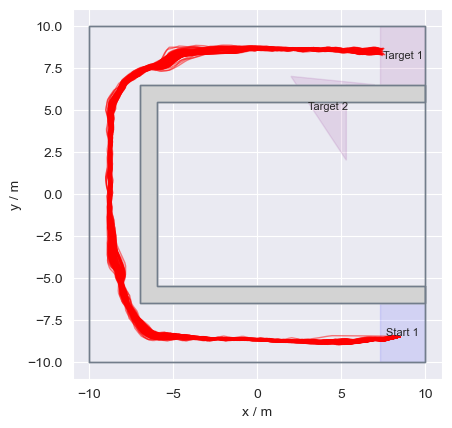

In [74]:

# Example usage:
complete_area = Polygon(
    [
        (10, -10),
        (10, 10),
        (-10, 10),
        (-10, -10),
    ]
)
obstacles = [
    Polygon(
        [
            (9.999, -6.5),
            (-7, -6.5),
            (-7, 6.5),
            (9.999, 6.5),
            (9.999, 5.5),
            (-6, 5.5),
            (-6, -5.5),
            (9.999, -5.5),
        ]
    ),
]

exit_polygons = [
    [(7.3, 6.5), (7.3, 9.999), (9.999, 9.999), (9.999, 6.5)],
    [(5.3, 6.5), (5.3, 1.999), (1.999, 6.999), (6.999, 6.5)],
]

start_polygons = [
    [(7.3, -6.5), (7.3, -9.999), (9.999, -9.999), (9.999, -6.5)],
]

obstacle = shapely.union_all(obstacles)
walkable_area = pedpy.WalkableArea(shapely.difference(complete_area, obstacle))

curve_c_traj = extract_trajectories(
    Path("../output/pedpy/CurveCBatch.txt")
)

plot_simulation(curve_c_traj, walkable_area, exit_polygons, start_polygons)

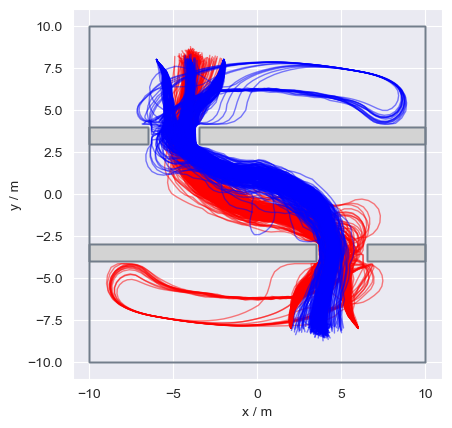

In [75]:
double_door_opposite_area = WalkableArea(
    # Room
    [
        (10, -10),
        (10, 10),
        (-10, 10),
        (-10, -10),
    ],
    obstacles=[
        # bottom right barrier
        [
            (9.999, -4.0),
            (6.5, -4.0),
            (6.5, -3.0),
            (9.999, -3.0)
        ],
        # bottom left barrier
        [
            (-9.999, -4.0),
            (3.5, -4.0),
            (3.5, -3.0),
            (-9.999, -3.0)
        ],
        # top right barrier
        [
            (-9.999, 4.0),
            (-6.5, 4.0),
            (-6.5, 3.0),
            (-9.999, 3.0)
        ],
        # top left barrier
        [
            (9.999, 4.0),
            (-3.5, 4.0),
            (-3.5, 3.0),
            (9.999, 3.0)
        ],
      
        
    ],
)

double_door_opposite_traj = extract_trajectories(
    Path("../output/pedpy/DoubleDoorOppositeBatch.txt")
)

plot_simulation(double_door_opposite_traj, double_door_opposite_area)
plt.show()

In [76]:
# from pedpy import compute_mean_speed_per_frame
# 
# from pedpy import compute_individual_speed, SpeedCalculation
# 
# frame_step = 2
# 
# individual_speed_single_sided = compute_individual_speed(
#     traj_data=double_door_opposite_traj[0],
#     frame_step=frame_step,
#     compute_velocity=True,
#     speed_calculation=SpeedCalculation.BORDER_SINGLE_SIDED,
# )
# 
# mean_speed = compute_mean_speed_per_frame(
#     traj_data=double_door_opposite_traj[0],
#     measurement_area=walkable_area,
#     individual_speed=individual_speed_single_sided,
# )
# 
# from pedpy import plot_speed, PEDPY_BLUE
# import matplotlib.pyplot as plt
# 
# plot_speed(
#     speed=mean_speed,
#     title="Mean speed in front of the bottleneck",
#     color=PEDPY_BLUE,
# )
# plt.show()

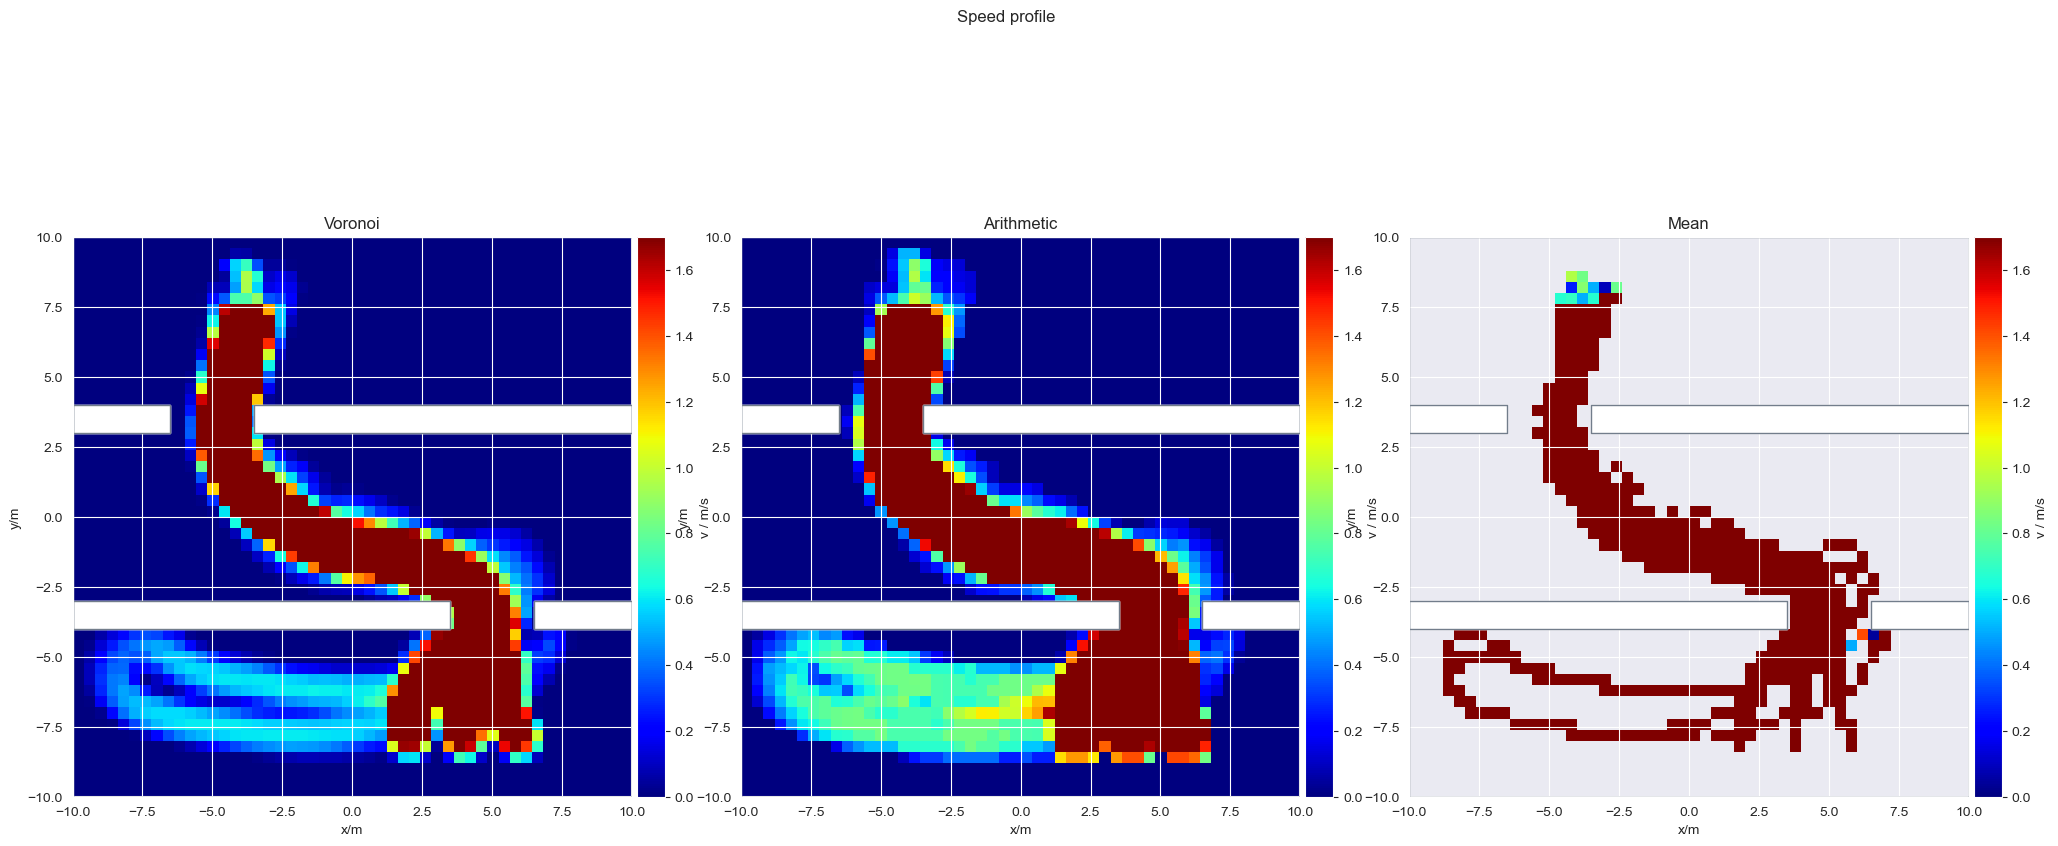

In [77]:
from pedpy import compute_speed_profile, SpeedMethod
from pedpy import (
    get_grid_cells,
    compute_grid_cell_polygon_intersection_area,
)
from pedpy import (
    compute_individual_voronoi_polygons,
    compute_individual_speed,
    SpeedCalculation,
    Cutoff,
)

individual_cutoff = compute_individual_voronoi_polygons(
    traj_data=double_door_opposite_traj[0],
    walkable_area=double_door_opposite_area,
    cut_off=Cutoff(radius=0.8, quad_segments=3),
)

individual_speed = compute_individual_speed(
    traj_data=double_door_opposite_traj[0],
    frame_step=5,
    speed_calculation=SpeedCalculation.BORDER_SINGLE_SIDED,
)

profile_data = individual_speed.merge(individual_cutoff)
profile_data = profile_data.merge(double_door_opposite_traj[0].data)
grid_size = 0.4
grid_cells, _, _ = get_grid_cells(
    walkable_area=double_door_opposite_area, grid_size=grid_size
)

min_frame_profiles = 250  # We use here just an excerpt of the
max_frame_profiles = 400  # trajectory data to reduce compute time

profile_data = profile_data[
    profile_data.frame.between(min_frame_profiles, max_frame_profiles)
]

(
    grid_cell_intersection_area,
    resorted_profile_data,
) = compute_grid_cell_polygon_intersection_area(
    data=profile_data, grid_cells=grid_cells
)

voronoi_speed_profile = compute_speed_profile(
    data=resorted_profile_data,
    walkable_area=double_door_opposite_area,
    grid_intersections_area=grid_cell_intersection_area,
    grid_size=grid_size,
    speed_method=SpeedMethod.VORONOI,
)

arithmetic_speed_profile = compute_speed_profile(
    data=resorted_profile_data,
    walkable_area=double_door_opposite_area,
    grid_intersections_area=grid_cell_intersection_area,
    grid_size=grid_size,
    speed_method=SpeedMethod.ARITHMETIC,
)

mean_speed_profile = compute_speed_profile(
    data=profile_data,
    walkable_area=double_door_opposite_area,
    grid_size=grid_size,
    speed_method=SpeedMethod.MEAN,
)

from pedpy import plot_profiles
import matplotlib.pyplot as plt

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, layout="constrained")
fig.set_size_inches(20, 10)
fig.suptitle("Speed profile")
cm = plot_profiles(
    walkable_area=double_door_opposite_area,
    profiles=voronoi_speed_profile,
    axes=ax0,
    label="v / m/s",
    vmin=0,
    vmax=1.7,
    title="Voronoi",
)
cm = plot_profiles(
    walkable_area=double_door_opposite_area,
    profiles=arithmetic_speed_profile,
    axes=ax1,
    label="v / m/s",
    vmin=0,
    vmax=1.7,
    title="Arithmetic",
)
cm = plot_profiles(
    walkable_area=double_door_opposite_area,
    profiles=mean_speed_profile,
    axes=ax2,
    label="v / m/s",
    vmin=0,
    vmax=1.7,
    title="Mean",
)

plt.show()

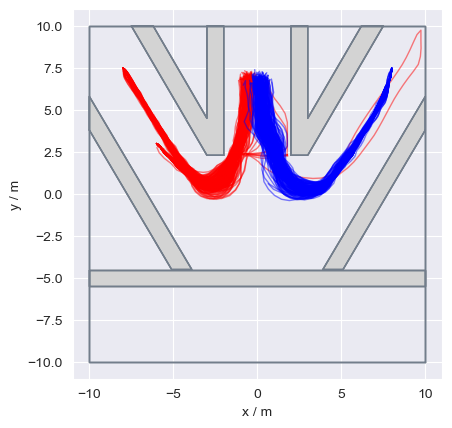

In [78]:
anchor_area = WalkableArea(
    # Room
    [
        (10, -10),
        (10, 10),
        (-10, 10),
        (-10, -10),
    ],
    obstacles=[
        # bottom left barrier
        [
            (-9.999, 3.8),
            (-9.999, 5.8),
            (-3.9, -4.5),
            (-5.1, -4.5),
        ],
        #top left anchor
        [
            (-2.0, 2.3),
            (-2.0, 9.999),
            (-3.0, 9.999),
            (-3.0, 4.5),
            (-6.2, 9.999),
            (-7.5, 9.999),
            (-3.0, 2.3),
        ],
        # bottom right barrier
        [
            (9.999, 3.8),
            (9.999, 5.8),
            (3.9, -4.5),
            (5.1, -4.5),
        ],
        #top left anchor
        [
            (2.0, 2.3),
            (2.0, 9.999),
            (3.0, 9.999),
            (3.0, 4.5),
            (6.2, 9.999),
            (7.5, 9.999),
            (3.0, 2.3),
        ],
        #bottom barrier
        [
            (-9.999, -4.51),
            (9.999, -4.51),
            (9.999, -5.5),
            (-9.999, -5.5),
        ]
        
    ],
)

anchor_traj = extract_trajectories(
    Path("../output/pedpy/AnchorBatch.txt")
)

plot_simulation(anchor_traj, anchor_area)
plt.show()

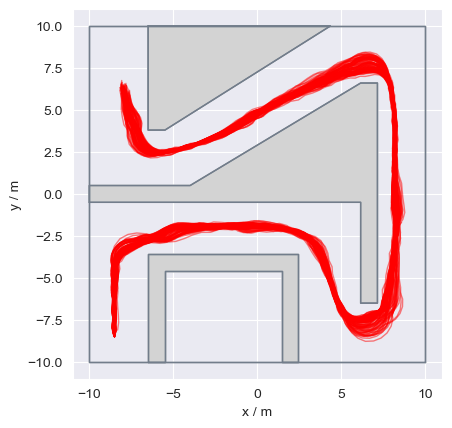

In [79]:
omega_area = WalkableArea(
    # Room
    [
        (10, -10),
        (10, 10),
        (-10, 10),
        (-10, -10),
    ],
    obstacles=[
        # bottom left barrier
        [
            (-6.5, -9.999),
            (-6.5, -3.6),
            (2.45, -3.6),
            (2.45, -9.999),
            (1.45, -9.999),
            (1.45, -4.6),
            (-5.5, -4.6),
            (-5.5, -9.999),
        ],    
        # mid barrier
        [
            (-9.999, -0.5),
            (6.15, -0.5),
            (6.15, -6.5),
            (7.15, -6.5),
            (7.15, 6.6),
            (6.15, 6.6),
            (-4.0, 0.5),
            (-9.999, 0.5),
        ],
        [
            (-6.5, 9.999),
            (-6.5, 3.8),
            (-5.5, 3.8),
            (4.35, 9.999),
            (2.45, 9.999),
            
        ]
    ],
)

omega_traj = extract_trajectories(
    Path("../output/pedpy/OmegaBatch.txt")
)

plot_simulation(omega_traj, omega_area)
plt.show()

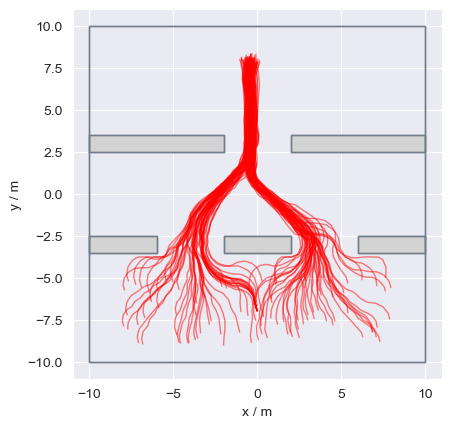

In [80]:
door_choice_area = WalkableArea(
    # Room
    [
        (10, -10),
        (10, 10),
        (-10, 10),
        (-10, -10),
    ],
    obstacles=[
        [
            (-9.999, 2.5),
            (-9.999, 3.5),
            (-2.0, 3.5),
            (-2.0, 2.5),
        ],
        [
            (9.999, 2.5),
            (9.999, 3.5),
            (2.0, 3.5),
            (2.0, 2.5),
        ],
        [
            (-9.999, -2.5),
            (-9.999, -3.5),
            (-6.0, -3.5),
            (-6.0, -2.5),
        ],
        [
            (9.999, -2.5),
            (9.999, -3.5),
            (6.0, -3.5),
            (6.0, -2.5),
        ],
        [
            (-2.0, -2.5),
            (-2.0, -3.5),
            (2.0, -3.5),
            (2.0, -2.5),
        ],

    ],
)

door_choice_traj = extract_trajectories(
    Path("../output/pedpy/DoorChoiceBatch.txt")
)

plot_simulation(door_choice_traj, door_choice_area)
plt.show()